In [5]:
from sdm.config import get_db_connection
from text_mining.utils import get_preprocessed_LDA
from text_mining.language import Language
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

## Task 1.3: LDA (Default)
- Run LDA with learned priors (alpha, eta).
- Choose an appropriate number of topics (K).
- Inspect topics and check if they make sense.

In [2]:
db = get_db_connection(db_path="../../../../data/twitter.db")
df = get_preprocessed_LDA(db, min_chars=1_000)
# df = get_tweet_corpora(db, min_chars=1000)
df.head()

,author_id,text_corpus,account_type,lang,stance,processed_corpus
0,8508262,L'accord de Paris adopté par les 195 pays #COP...,Private individuals,fr,For,paris adopté pays via lemondefr pcanfin ça fai...
1,3297659759,RT @ecocosmopolita: El Acuerdo de París fue me...,Advocacy actors,es,For,ecocosmopolita acuerdo parís mejor esperado le...
2,259352661,RT @RAN: Delegates at #COP21 must work to prot...,Advocacy actors,en,For,ran delegates must work protect indonesia peop...
3,955903212,RT @guardianeco: All the NGO reaction to the d...,Advocacy actors,en,For,guardianeco ngo reaction draft paris climate t...
4,2482232082,".@CFigueres: ""I used to say we must we can w...",Political actors,es,Unclear,cfigueres i used to say we must we can we will...


In [6]:
# K of ~7 seems to get the major langs, higher ones allow more granular topics and languages
# but also seems to create a lot of what seems like nonsense topics (granted most are not in english)
# and I have no idea what words/hashtags/people are in relation to the COP event.
K = 8
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['processed_corpus'])
lda = LatentDirichletAllocation(n_components=K, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=8, random_state=42)

In [49]:
n_top_words = 15
feature_names = vectorizer.get_feature_names_out()

# Display the topics
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx}:")
    print("Top words")
    print("|".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Topic #0:
Top words
climate|amp|climatechange|paris|unfccc|change|world|today|agreement|energy|lpaa|new|action|event|live

Topic #1:
Top words
acuerdo|cambioclimático|parís|climático|ambassades|cambio|clima|el|cumbre|cambioclimatico|paris|países|hoy|cmnucc|día

Topic #2:
Top words
climate|paris|climatechange|amp|change|deal|talks|world|agreement|action|new|global|text|energy|countries

Topic #3:
Top words
emblème|découvrez|vidéo|bravo|partagez|créer|contribué|tweet|découvrir|façonne|retweetez|prêt|dès|laurentfabius|royalsegolene

Topic #4:
Top words
afp|elisedepenoux|climatechange|climat|paris|amp|future|infloodwetrust|accord|pays|projet|climatique|preguntas|faqs|cop

Topic #5:
Top words
climatechange|cdnpoli|amp|climate|nuclear|design|green|climatehealth|eco|paris|ocean|text|lt|science|blog

Topic #6:
Top words
climat|pour|paris|direct|laurentfabius|accord|gt|climatique|texte|plus|du|pays|sur|fhollande|royalsegolene

Topic #7:
Top words
sassoui|nrcg|sassou|denis|nguesso|du|planète|est

In [11]:
# Like elbow method in K-means Data Mining:
perplexities = []
for k in range(2, 80, 2):
    lda = LatentDirichletAllocation(n_components=k, random_state=42, n_jobs=-1)
    lda.fit(X)
    perplexities.append({"perplexity":lda.perplexity(X), "K": k})


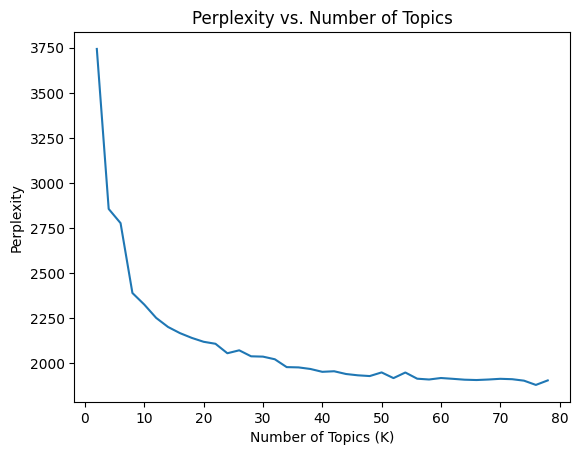

In [13]:
sns.lineplot(data=pd.DataFrame(perplexities), x="K", y="perplexity")
plt.xlabel("Number of Topics (K)")
plt.ylabel("Perplexity")
plt.title("Perplexity vs. Number of Topics")
plt.show()

## Task 1.4: Evaluation
- Evaluate inferred topics via blind evaluations:
  - Identify intruders.
  - Relate sampled texts to topics.
- Reflect on the evaluation process.
1. **First Task (Repeated N times):**
   - Randomly select a topic (z).
   - Randomly sample S units related to topic z (try S = 2).
   - Randomly sample 1 unit not related to topic z.
   - Shuffle the S+1 units and identify the intruder (the one not related to topic z).
   - You can adjust S if needed.

2. **Second Task (Repeated N times):**
   - Randomly select a topic (z).
   - Randomly sample S units related to topic z (try S = 1).
   - Based on the sampled units and descriptions of topics, try to identify the topic (z). 

In [58]:
def identify_intruder(doc_topic_dist, S=2):
    z = np.random.choice(doc_topic_dist.shape[1])
    
    # Get the documents that have the highest probability for topic z
    topic_probs = doc_topic_dist[:, z]
    
    # Sample S documents based on their topic probability for topic z
    sampled_docs = np.random.choice(df.index, size=S, p=topic_probs/np.sum(topic_probs), replace=False)
    
    # Pick intruder
    non_z_docs = np.where(np.max(doc_topic_dist, axis=1) != z)[0]
    non_z_doc = np.random.choice(non_z_docs)
    
    # Shuffle the S+1 documents (including the intruder)
    shuffled_docs = np.random.permutation(np.append(sampled_docs, non_z_doc))
    
    # Display the shuffled documents for you to identify the intruder
    for doc_idx in shuffled_docs:
        intruder_str = "\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tvvv-Intruder-vvv" if doc_idx not in sampled_docs else ""
        print(f"---Document {doc_idx}:{intruder_str}")  # - Topic Distribution: {doc_topic_dist[doc_idx]}")
        # print("|".join([feature_names[i] for i in topic.argsort()[:-5 - 1:-1]]))
        random_words = np.random.choice(df.loc[doc_idx, :]["processed_corpus"].split(), size=10)
        print("Ten random words from corpus:")
        print("|".join(random_words))
        print("Processed Corpus:")
        print(df.loc[doc_idx, :]["processed_corpus"])
    
    print("\nTry to identify the intruder document\n")

In [61]:
N = 10
dist = lda.transform(X)
for _ in range(N):
    identify_intruder(dist, S=2)
# put scores here: <guess> (<answer>)
# finn [232 (534), 244 (244), 872 (872), 788 (788), 784 (644), 879 (364), 792 (792), 668 (204), 147 (74), 161 (161)]
# total: 5/10

---Document 886:																vvv-Intruder-vvv
Ten random words from corpus:
family|via|published|stunt|friends|grandes|text|cansativos|couple|leva
Processed Corpus:
depois de dias cansativos mas muito frutuosos na em paris ecumenical family represented great moment couple days actalliance good morning act delegation actclimate isaiahkipyegon vchinoko valterhugomuniz actalliance protest stunt gender justice via youtube actalliance protest stunt pan africa cycling caravan via youtube actalliance act alliance delegation analyzing new text published actclimate actalliance mattias södeberg talks latest draft negotiating text actclimate cada novo passo nos leva grandes descobertas paris nunca canso de paris therusnoinsta stunning paris nofilter friends tanzania great quote today segunda pátria therusnoinsta na procurando promover um futuro promissor para muitos mas
---Document 185:
Ten random words from corpus:
helenclarkundp|benefits|part|apg|clean|climatebonds|creative|assets|city|clima

In [ ]:
import numpy as np

# Refactored function
def identify_topic_from_sample(doc_topic_dist, df, feature_names, lda, S=1, n_top_words=12):
    z = np.random.choice(doc_topic_dist.shape[1])
    
    # Get the documents that have the highest probability for topic z
    topic_probs = doc_topic_dist[:, z]
    
    # Sample S documents based on their topic probability for topic z
    sampled_docs = np.random.choice(df.index, size=S, p=topic_probs/np.sum(topic_probs), replace=False)
    
    # Print out the top terms for all topics
    print("Top terms for each topic:")
    for topic_idx, topic in enumerate(lda.components_):
        top_terms = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic #{topic_idx}: {' | '.join(top_terms)}")
    
    print("\nSampled documents:")
    for doc_idx in sampled_docs:
        intruder_str = f"\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tvvv-Topic {z}-vvv"
        random_words = np.random.choice(df.loc[doc_idx, :]["processed_corpus"].split(), size=10)
        print(f"---Document {doc_idx}{intruder_str}")
        print("Ten random words from corpus:")
        print("|".join(random_words))
        print("Processed Corpus:")
        print(df.loc[doc_idx, :]["processed_corpus"])
    
    print("\nTry to identify the topic of the sampled documents!\n")

N = 10
for _ in range(N):
    identify_topic_from_sample(dist, df, feature_names, lda, S=1)
# put scores here:
# finn: TODO

Top terms for each topic:
Topic #0: climate | amp | climatechange | paris | unfccc | change | world | today | agreement | energy | lpaa | new
Topic #1: acuerdo | cambioclimático | parís | climático | ambassades | cambio | clima | el | cumbre | cambioclimatico | paris | países
Topic #2: climate | paris | climatechange | amp | change | deal | talks | world | agreement | action | new | global
Topic #3: emblème | découvrez | vidéo | bravo | partagez | créer | contribué | tweet | découvrir | façonne | retweetez | prêt
Topic #4: afp | elisedepenoux | climatechange | climat | paris | amp | future | infloodwetrust | accord | pays | projet | climatique
Topic #5: climatechange | cdnpoli | amp | climate | nuclear | design | green | climatehealth | eco | paris | ocean | text
Topic #6: climat | pour | paris | direct | laurentfabius | accord | gt | climatique | texte | plus | du | pays
Topic #7: sassoui | nrcg | sassou | denis | nguesso | du | planète | est | congo | bassin | brazzaville | climatiqu